In [7]:
from vicreg import SelfSupervisedMethod
# from model_params import EigRegParams
from model_params import VICRegParams

from attr import evolve
 

# config = VICRegParams(dataset_name="imagenet", batch_size=16)
# data parameters
# data parameters
data_params = list()
data_params.append({
                    'train_path' :"/home/richard/Projects/06_research/semes_gaf/gaf_data/train",
                    'test_path' :"/home/richard/Projects/06_research/semes_gaf/gaf_data/test",
                    'checkpoint': 'checkpoint_semes'
                    })




selector = 0

config = evolve(VICRegParams(), 
                encoder_arch = "ws_resnet18") # resnet18, resnet34, resnet50


# method = SelfSupervisedMethod(config)
# Initialize your ResNet model
checkpoint = data_params[selector]['checkpoint']
# path = f'/home/richard/Projects/06_research/gaf_lightning/self_supervised/{checkpoint}/last.ckpt'
path = '/home/richard/Projects/06_research/semes_gaf/self_supervised/checkpoint_semes/last.ckpt'

method = SelfSupervisedMethod.load_from_checkpoint(checkpoint_path=path)
                                                   # hparams_file='lightning_logs/version_9/hparams.yaml')

# Set the model to evaluation mode
method.eval()

SelfSupervisedMethod(
  (model): ResNet(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): GroupNorm(32, 64, eps=1e-05, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [8]:
import torch
from torchvision import transforms
from PIL import Image
import glob, os
import numpy as np


# inference


In [9]:
from utils import get_random_file
train_path = data_params[selector]['train_path']
random_file = get_random_file(train_path)
img_size = len(np.load(random_file)['data'])


In [14]:
from pyts.image import GramianAngularField, MarkovTransitionField
gaf_function = GramianAngularField(image_size=img_size, 
                                   method="difference",
                                   sample_range=(0,1))

def load_image(filepath):

    data = np.load(filepath)['data'].astype(np.float32)
    
    data = data.reshape((1,-1))
    gaf_image = gaf_function.transform(data)[0]
    mtf_image = gaf_image
    # mtf_image = self.mt_function.transform(data)[0]
    image = torch.from_numpy(np.stack([gaf_image, mtf_image], axis=0).astype(np.float32))
    return image


def list_directories(path):
    entries = os.listdir(path)
    directories = [ entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
    return directories

image_dir = data_params[selector]['train_path']
classes = list_directories(image_dir)

def inference(method, classes, path, transform):
    batch_size = 256
    image_tensors = []
    result = []
    labels = []

    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    device = torch.device('cuda:1')
    method.model.to(device)
    method.projection_model.to(device)


    for key in classes:
        image_dir = path + '/'  + key 
        for img_name in os.listdir(image_dir):
            image_path = os.path.join(image_dir, img_name)
            # image = Image.open(image_path)
            input_tensor = load_image(image_path)
            # image = image.convert('RGB')

            # Preprocess the image
            input_tensor = transform(input_tensor).unsqueeze(0)  # Add batch dimension
            image_tensors.append(input_tensor)

            # perform batching
            if len(image_tensors) == batch_size:
                batch_tensor = torch.cat(image_tensors).to(device)
                # Use the pre-trained model to extract features
                with torch.no_grad():
                    emb = method.model(batch_tensor)
                    projection = method.projection_model(emb)
                    # projection = method.model(input_tensor)
                result.extend(projection.cpu())
                # reset back to 0
                image_tensors = []


            labels.append(img_name)

    if len(image_tensors) > 0:
        batch_tensor = torch.cat(image_tensors).to(device)
        # Use the pre-trained model to extract features
        with torch.no_grad():
            emb = method.model(batch_tensor)
            projection = method.projection_model(emb)
            # projection = method.model(input_tensor)
        result.extend(projection.cpu())

    return result, labels



In [17]:
from dataload import normalize_params
import warnings
warnings.filterwarnings("ignore")

path = data_params[selector]['train_path']
normalize_means, normalize_stds = normalize_params(path).calculate_mean_std()
transform = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Normalize(mean=normalize_means, std=normalize_stds),
])

result, labels = inference(method, classes, path, transform)


In [18]:
torch.cuda.empty_cache() # PyTorch thing

In [8]:
len(result)

2905

In [9]:
result[0].shape

torch.Size([64])

# K-means

In [19]:
import numpy as np
import pandas as pd
data = np.array(result)
print(data.shape)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

(2905, 64)


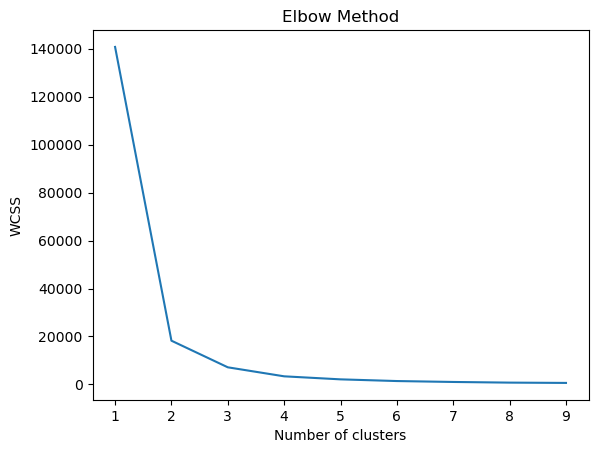

In [20]:
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the elbow method
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(reduced_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [21]:

# Choose the number of clusters, say 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data)

In [22]:
# cluster_indices = np.where(clusters == 0)
chosen_data = reduced_data[clusters==0]
print(sum(clusters==0))
print(sum(clusters==1))
print(sum(clusters==2))

import plotly.express as px

fig = px.scatter(x=reduced_data[:, 0], y=reduced_data[:, 1], text=labels)
fig.show()


2558
135
212


In [23]:

# import plotly.express as px
import plotly.graph_objs as go

plots = []
for cluster_id in range(3):
    print('-'*10)
    print("cluster_id: ", cluster_id)
    print("number points: ", sum(clusters==cluster_id))
    selected_data = reduced_data[clusters==cluster_id]
    selected_labels = np.array(labels)[clusters==cluster_id]
    plots.append(go.Scatter(x=selected_data[:, 0], y=selected_data[:, 1], mode='markers', text=selected_labels))


fig = go.Figure(data=plots)
fig.update_traces(visible='legendonly')
fig.show()


----------
cluster_id:  0
number points:  2558
----------
cluster_id:  1
number points:  135
----------
cluster_id:  2
number points:  212


# DBSSCAN

In [15]:
import numpy as np
import pandas as pd
data = np.array(result)
print(data.shape)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)
X = data

(2905, 64)


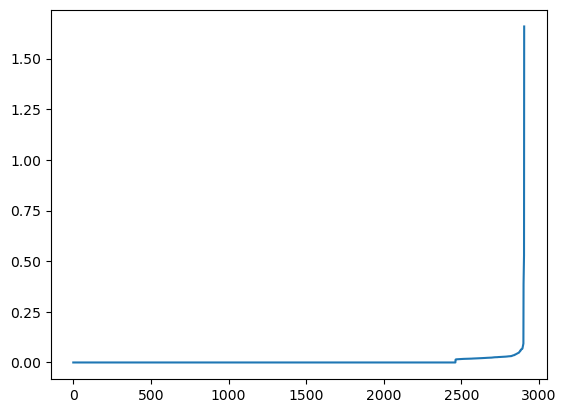

In [16]:
# eps selection
# find knee-point
from sklearn.neighbors import NearestNeighbors
# Step 1: Estimate eps with k-distance plot
n_neighbors=10
neigh = NearestNeighbors(n_neighbors=n_neighbors)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances[:, 5], axis=0)
plt.plot(distances)
plt.show()

In [17]:
distances, indices =nbrs.kneighbors(X)

In [22]:
import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=100).fit(X)
clusters = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 40


In [23]:

# import plotly.express as px
import plotly.graph_objs as go

plots = []
for cluster_id in range(-1,n_clusters_):
    print('-'*10)
    print("cluster_id: ", cluster_id)
    print("number points: ", sum(clusters==cluster_id))
    selected_data = reduced_data[clusters==cluster_id]
    selected_labels = np.array(labels)[clusters==cluster_id]
    plots.append(go.Scatter(x=selected_data[:, 0], y=selected_data[:, 1], mode='markers', text=selected_labels))


fig = go.Figure(data=plots)
# fig.update_traces(visible='legendonly')
fig.show()


----------
cluster_id:  -1
number points:  40
----------
cluster_id:  0
number points:  2865


# Plot Relevant Time Series

we can plot the time series of the clusters

In [24]:
import re
import plotly.graph_objs as go
from tqdm import tqdm


In [25]:

# choose your cluster
cluster_id = -1
# or you can manually state desired clusters
# cluster_tuples = [(70,8),(70,6)]

def extract_num(example):
    pattern = r'img(\d+)_(\d+).npz'
    match = re.match(pattern, example)
    num1, num2 = match.groups()
    num1, num2 = int(num1), int(num2)
    return num1, num2

selected_labels = np.array(labels)[clusters==cluster_id]
cluster_tuples = sorted([extract_num(name) for name in selected_labels])
# because we have npz files now


In [26]:

plots = []

for num1,num2 in cluster_tuples:
    key_tuple = (num1,num2)
    data_path = f"/home/richard/Projects/06_research/semes_gaf/gaf_data/train/0/img{num1}_{num2}.npz"
    segment=np.load(data_path)['data']
    plots.append(go.Scatter(y=segment, mode='lines', name=f"{key_tuple}"))



In [28]:

fig = go.Figure(data=plots)
fig.update_traces(visible='legendonly')
fig.show()

